# Generative models - Normalizing flows

### Author: Philippe Esling (esling@ircam.fr)

Most of the real-world probability distributions that we are interested into are too complex and do not have a closed-form analytical solution. Hence, Gaussians are widely used, but often prove to be too simple to model complex datasets. Recently, the idea of *Normalizing Flows* [[1](#reference1),[2](#reference)] has been formalized to address this problem and be able to rely on richer probability distributions. The main idea is to start from a simple probability distribution and approximate a complex multimodal density by *transforming* the simpler density through a sequence of invertible nonlinear transforms. This allows to rely on distributions of arbitrary complexity and also learn the parameters of these transforms depending only on some mild conditions.

To fully understand this blazing tool, we will see in this tutorial
1. A recap on [Tensorflow distributions](#distribs) module and how to use it
2. How transforming a distribution is expressed as a [change of variables](#change) leading to a flow
3. How we can [chain multiple transforms](#chaining) leading to the overall framework of normalizing flows
4. Understanding the original [planar flow](#planar), its parameters and how to implement it
5. Defining [learnable flows](#learning) and performing optimization on a target density
6. Combining [flows with VAEs](#vae) (**exercise**)

<a id="distribs"></a>
### Tensorflow distributions

In this tutorial, we are going to rely on the novel [Tensorflow distributions module](https://www.tensorflow.org/probability/), which is defined in `tensorflow_distribution`. Most notably, we are going to rely both on the `distributions` and `bijectors` objects.

In [7]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as distrib
from tensorflow_probability import bijectors as biject
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

Inside this toolbox, we can already find some of the major probability distributions that we are used to deal with


In [8]:
p = distrib.Normal(loc=0, scale=1)
p = distrib.Bernoulli(probs=[0.5])
p = distrib.Beta(concentration1=[0.5], concentration0=[0.5])
p = distrib.Gamma(concentration=[1.0], rate=[1.0])

The interesting aspect of these `Distribution` objects is that we can both obtain some samples from it through the `sample` (or `sample_n`) function, but we can also obtain the analytical density at any given point through the `log_prob` function

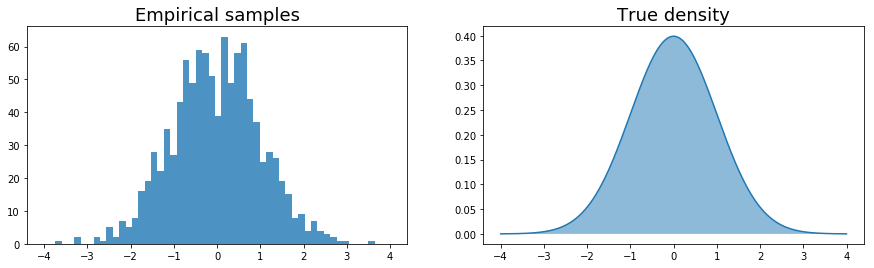

In [9]:
# Based on a normal
n = distrib.Normal(0, 1)
# Obtain some samples
samples = n.sample((1000, ))
# Evaluate true density at given points
density = tf.exp(n.log_prob(x)).numpy()
# Plot both samples and density
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
ax1.hist(samples, 50, alpha=0.8);
ax1.set_title('Empirical samples', fontsize=18);
ax2.plot(x, density); ax2.fill_between(x, density, 0, alpha=0.5)
ax2.set_title('True density', fontsize=18);

<a id="change"></a>
## Transforming distributions

### Change of variables and flow

In order to transform a probability distribution, we can perform a *change of variable*. In general, change of variables can be performed in any number of ways. However, here we are interested in probability distributions, which means that we need to *scale* our transformed density so that the total probability still sums to one. This is directly measured with the determinant of our transform (if you need more intuitive examples, you can check the great [Eric Jang's tutorial](https://blog.evjang.com/2018/01/nf1.html)).Hence, we can transform a probability distribution by using an invertible mapping and somehow scaling by the determinant of this mapping. 

Let $\mathbf{z}\in\mathcal{R}^d$ be a random variable with distribution $q(\mathbf{z})$ and $f:\mathcal{R}^d\rightarrow\mathcal{R}^d$ an invertible smooth mapping (meaning that $f^{-1} = g$ and $g\circ f(\mathbf{z})=\mathbf{z}'$. We can use $f$ to transform $\mathbf{z}\sim q(\mathbf{z})$. The resulting random variable $\mathbf{z}'=f(\mathbf{z})$ has the following probability distribution

$$
q(\mathbf{z}')=q(\mathbf{z})\left|\text{ det}\frac{\delta f^{-1}}{\delta \mathbf{z}'}\right| = q(\mathbf{z})\left|\text{ det}\frac{\delta f}{\delta \mathbf{z}}\right|^{-1}
\tag{1}
$$

where the last equality is obtained through both the inverse function theorem [1] and the property of Jacobians of invertible functions. Therefore, we can transform probability distributions with this property.

Fortunately, this can be easily implemented in Tensorflow with the `Bijector` classes, that already defines some basic probability distribution transforms. For instance, if we define $\mathbf{z}\sim q_0(\mathbf{z})=\mathcal{N}(0, 1)$, we can apply the transform $\mathbf{z}'=exp(\mathbf{z})$ so that $\mathbf{z}'\sim q_1(\mathbf{z}')$

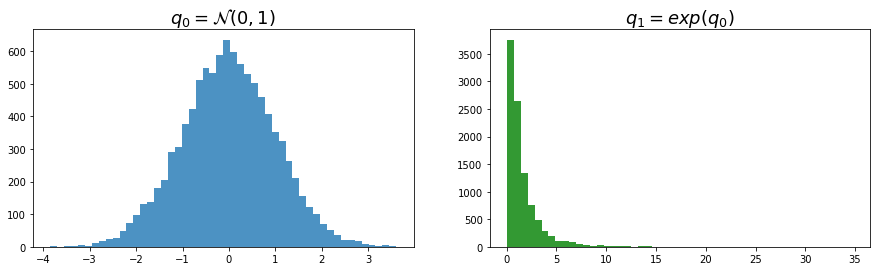

In [10]:
q0 = distrib.Normal(0, 1)
exp_t = biject.Exp()
q1 = distrib.TransformedDistribution(q0, exp_t)
samples_q0 = q0.sample((int(1e4),))
samples_q1 = q1.sample((int(1e4),))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.hist(samples_q0, 50, alpha=0.8);
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18);
ax2.hist(samples_q1, 50, alpha=0.8, color='g');
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);

But remember as the objects `q0` and `q1` are defined as `Distribution`, we can actually observe their true densities instead of just empirical samples

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Helvetica
  (prop.get_family(), self.defaultFamily[fontext]))


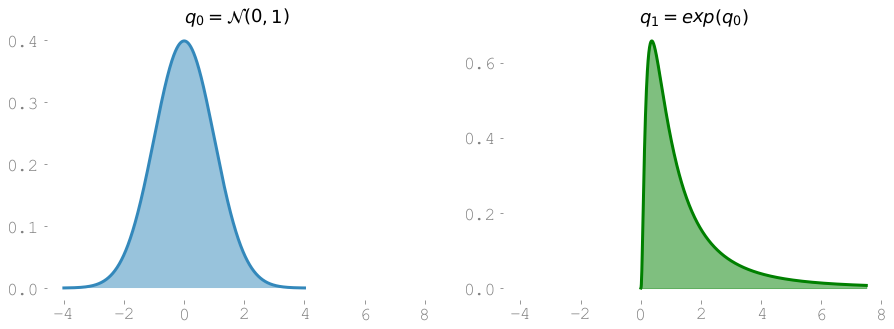

In [11]:
import os
import matplotlib as mpl

def hdr_plot_style():
    mpl.rcParams.update({'font.size': 18, 'lines.linewidth': 3, 'lines.markersize': 15})
    # avoid type 3 (i.e. bitmap) fonts in figures
    mpl.rcParams['ps.useafm'] = True
    mpl.rcParams['pdf.use14corefonts'] = True
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams['font.sans-serif'] = 'Courier New'
    mpl.rcParams['text.hinting'] = False
    # Set colors cycle
    colors = mpl.cycler('color', ['#3388BB', '#EE6666', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
    plt.rc('axes', facecolor='#FFFFFF', edgecolor='none', axisbelow=True, grid=True, prop_cycle=colors)
    plt.rc('grid', color='w', linestyle='solid')
    plt.rc('xtick', direction='out', color='gray')
    plt.rc('ytick', direction='out', color='gray')
    plt.rc('patch', edgecolor='#E6E6E6')
hdr_plot_style()
x2 = np.linspace(-0.5, 7.5, 1000)
q0_density = tf.exp(q0.log_prob(tf.convert_to_tensor(x, dtype='float32'))).numpy()
q1_density = tf.exp(q1.log_prob(tf.convert_to_tensor(x2, dtype='float32'))).numpy()
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
ax1.plot(x, q0_density); ax1.fill_between(x, q0_density, 0, alpha=0.5)
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18);
ax2.plot(x2, q1_density, color='g'); ax2.fill_between(x2, q1_density, 0, alpha=0.5, color='g')
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);
fig.savefig('transform.pdf')

What we obtain here with `q1` is actually the `LogNormal` distribution. Interestingly, several distributions in the `tensorflow_probability.distributions` module are already defined based on `TransformedDistribution`. You can convince yourself of that by lurking in the code of the [`tensorflow_probability.distributions.LogNormal`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/LogNormal)

<a id="chaining"></a>
### Chaining transforms (normalizing flows)

Now, if we start with a random vector $\mathbf{z}_0$ with distribution $q_0$, we can apply a series of mappings $f_i$, $i \in 1,\cdots,k$ with $k\in\mathcal{N}^{+}$ and obtain a normalizing flow. Hence, if we apply $k$ normalizing flows, we obtain a chain of change of variables

$$
\mathbf{z}_k=f_k\circ f_{k-1}\circ...\circ f_1(\mathbf{z}_0)
\tag{2}
$$

Therefore the distribution of $\mathbf{z}_k\sim q_k(\mathbf{z}_k)$ will be given by
   
   $$
   \begin{align}
   q_k(\mathbf{z}_k) &= q_0(f_1^{-1} \circ f_{2}^{-1} \circ ... \circ f_k^{-1}(\mathbf{z}_k))\prod_{i=1}^k\left|\text{det}\frac{\delta f^{-1}_i}{\delta\mathbf{z}_{i}}\right|\\
   &= q_0(\mathbf{z_0})\prod_{i=1}^k\left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|^{-1}
   \end{align}
   \tag{3}
   $$
    
where we compute the determinant of the Jacobian of each normalizing flow (as explained in the previous section). This series of transformations can transform a simple probability distribution (e.g. Gaussian) into a complicated multi-modal one. As usual, we will rely on log-probabilities to simplify the computation and obtain 

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right| 
\tag{4}
$$


To be of practical use, however, we can consider only transformations whose determinants of Jacobians are easy to compute. Of course, we can perform any amount of combined transformations, and it also works with multivariate distributions. Here, this is demonstrated by transforming a `MultivariateNormalDiag` successively with an `Exp` and `Affine` transforms. (Note that the final distribution `q2` is defined as a `TransformedDistribution` directly with a *sequence* of transformations)

Instructions for updating:
`Affine` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Matvec*)` where `tfb.Matvec*` is one of `MatvecDiag`, `MatvecTriL`, or `MatvecLinearOperator`.


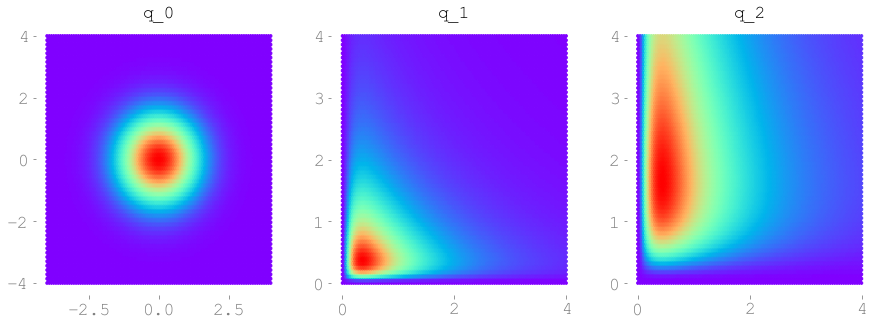

In [12]:
z_tf = tf.convert_to_tensor(z, dtype='float32')
q0 = distrib.MultivariateNormalDiag(tf.zeros(2), tf.ones(2))
# Define an affine transform
f1 = biject.Exp()
q1 = distrib.TransformedDistribution(q0, f1)
# Define an additional transform
f2 = biject.Affine(shift=[0.2, 1.5])
# Here I define on purpose q2 as a sequence of transforms on q0
q2 = distrib.TransformedDistribution(q0, biject.Chain([f1, f2]))
# Plot all these lads
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=tf.exp(q0.log_prob(z_tf)), cmap='rainbow')
ax1.set_title('q_0', fontsize=18);
ax2.hexbin(z[:,0], z[:,1], C=tf.exp(q1.log_prob(z_tf)), cmap='rainbow')
ax2.set_title('q_1', fontsize=18);
ax3.hexbin(z[:,0], z[:,1], C=tf.exp(q2.log_prob(z_tf)), cmap='rainbow')
ax3.set_title('q_2', fontsize=18);

<a id="planar"></a>
## Normalizing flows

Now, we are interested in normalizing flows as we could define our own flows. And, most importantly, we could optimize the parameters of these flow in order to fit complex and richer probability distributions. We will see how this plays out by trying to implement the *planar flow* proposed in the original paper by Rezende [1].

### Planar flow

 A planar normalizing flow is defined as a function of the form

   $$
   f(\mathbf{z})=\mathbf{z}+\mathbf{u}h(\mathbf{w}^T\mathbf{z}+b)
   \tag{5}
   $$

   where $\mathbf{u}\in\mathbb{R}^D$ and $\mathbf{w}\in\mathbb{R}^D$ are vectors (called here scale and weight), $b\in\mathbb{R}$ is a scalar (bias) and $h$ is an activation function. These transform functions are chosen depending on the fact that
1. the determinant of their Jacobian can be computed in linear time
2. the transformation is invertible (under usually mild conditions only)
   
As shown in the paper, for the planar flow, the determinant of the Jacobian can be computed in $O(D)$ time by relying on the matrix determinant lemma

$$
\psi(\mathbf{z})=h'(\mathbf{w}^T\mathbf{z}+b)\mathbf{w}
\tag{6}
$$

$$
\left|\text{det}\frac{\delta f}{\delta\mathbf{z}}\right| = \left|\text{det}\left(\mathbf{I}+\mathbf{u}\psi(\mathbf{z})^{T}\right)\right|=\left|1+\mathbf{u}^T\psi(\mathbf{z})\right|
\tag{7}
$$

Therefore, we have all definitions that we need to implement this flow as a `Bijector` object. Note that here the non-linear activation function $h$ is selected as a $tanh$. Therefore the derivative $h'$ is $1-tanh(x)^2$

In [13]:
class PlanarFlow(biject.Bijector):

    def __init__(self, weight, scale, bias):
        super(PlanarFlow, self).__init__(
        forward_min_event_ndims=2,
        inverse_min_event_ndims=2)
        self.bijective = False
        self.weight = weight
        self.scale = scale
        self.bias = bias
        
    def h(self, z):
        return tf.math.tanh(z)

    def h_prime(self, z):
        return 1.0 - tf.math.tanh(z) ** 2.0
    
    def _forward(self, z):
        f_z = tf.tensordot(z, self.weight, 1) + self.bias
        return tf.add(z, tf.tensordot(self.h(f_z), self.scale, 0))

    def _inverse_log_det_jacobian(self, z):
        f_z = tf.tensordot(z, self.weight, 1) + self.bias
        psi = tf.tensordot(self.h_prime(f_z), self.weight, 0)
        det = tf.math.abs(1.0 + tf.tensordot(psi, self.scale, 1))
        return tf.math.log(det)

As before, we can witness the effect of this transform on a given `MultivariateNormal` distribution. You should note here that I am using the density estimation for `q0`, but only display empirical samples from `q1`.

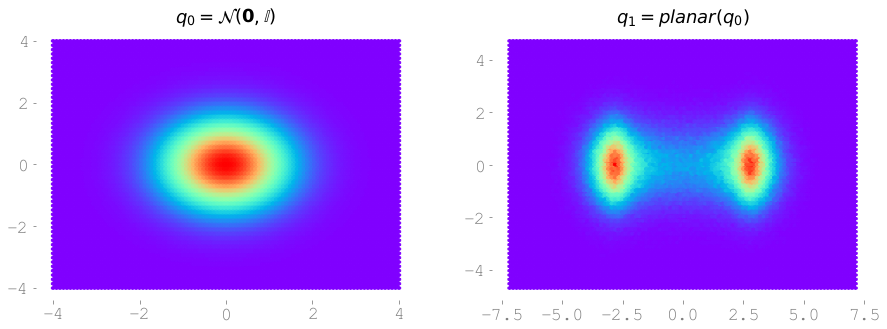

In [14]:
w = tf.convert_to_tensor([3., 0], dtype='float32')
u = tf.convert_to_tensor([2, 0], dtype='float32')
b = tf.convert_to_tensor([0], dtype='float32')
q0 = distrib.MultivariateNormalDiag(tf.zeros(2), tf.ones(2))
flow_0 = PlanarFlow(w, u, b)
q1 = distrib.TransformedDistribution(q0, flow_0)
q1_samples = q1.sample(int(1e6))
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=tf.exp(q0.log_prob(z_tf)), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(q1_samples[:,0], q1_samples[:,1], cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

The reason for this is that the `PlanarFlow` is not invertible in all regions of the space. However, if we recall the mathematical reasoning of the previous section, we can see how the change of variables plays out if we are able to compute the determinant of the Jacobian of this transform.

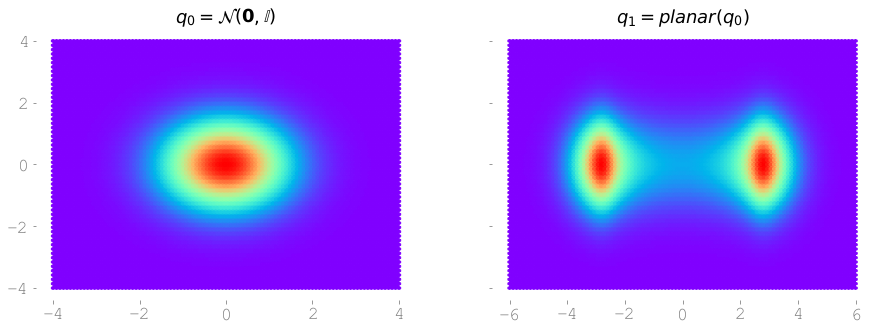

In [15]:
q0_density = tf.exp(q0.log_prob(z_tf))
# Apply our transform on coordinates
f_z = flow_0(z_tf)
# Obtain our density
q1_density = q0_density / np.exp(flow_0._inverse_log_det_jacobian(z_tf))
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

So we were able to "split" our distribution and transform a unimodal gaussian into a multimodal distribution ! Pretty neat 

### Visualizing parameters effects

Here, we provide a little toy example so that you can play around with the parameters of the flow in order to get a better understanding of how it operates. As put forward by Rezende [1], this flow is related to the hyperplane defined by $\mathbf{w}^{T}\mathbf{z}+b=0$ and transforms the original density by applying a series of contractions and expansions in the direction perpendicular to this hyperplane.


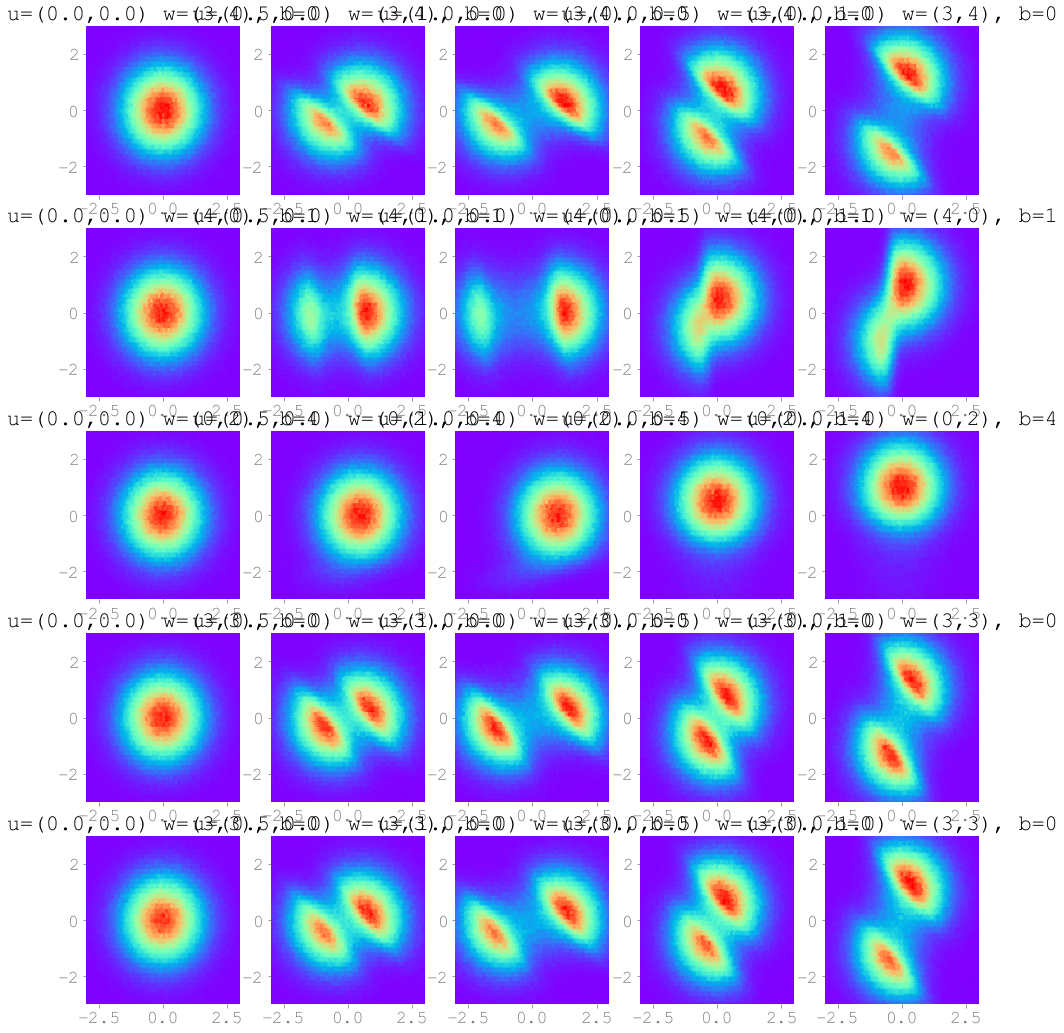

In [16]:
id_figure=1
plt.figure(figsize=(16, 18))
for i in np.arange(5):
    # Draw a random hyperplane
    w = tf.convert_to_tensor(np.random.rand(2) * 5, dtype='float32')
    b = tf.convert_to_tensor(np.random.rand(1) * 5, dtype='float32')
    for j in np.arange(5):
        # Different effects of scaling factor u on the same hyperplane (row)
        u = tf.convert_to_tensor([((j < 3) and (j / 2.0) or 0), ((j > 2) and ((j - 2) / 2.0) or 0)], dtype='float32')
        flow_0 = PlanarFlow(w, u, b)
        q1 = distrib.TransformedDistribution(q0, flow_0)
        q1_samples = q1.sample((int(1e6), ))
        plt.subplot(5,5,id_figure)
        plt.hexbin(q1_samples[:,0], q1_samples[:,1], cmap='rainbow')
        plt.title("u=(%.1f,%.1f)"%(u[0],u[1]) + " w=(%d,%d)"%(w[0],w[1]) + ", " + "b=%d"%b)
        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        id_figure += 1

<a id="learning"></a>
## Optimizing normalizing flows

Now that we have this magnificent tool, we would like to apply this in order to learn richer distributions and perform *inference*. Now, we have to deal with the fact that the `Transform` object is not inherently parametric and cannot yet be optimized similarly to other modules.

To do so, we will start by defining our own `Flow` class which can be seen both as a `Transform` and also a `Module`that can be optmized

In [17]:
class Flow(biject.Bijector, tf.Module):
    
    def __init__(self, **args):
        biject.Bijector.__init__(self, **args)
        tf.Module.__init__(self)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

Thanks to this little trick, we can use the same `PlanarFlow` class as before, that we put back here just to show that the only change is that it now inherits from the `Flow` class (with the small added bonus that now parameters of this flow are also registered in the `Module` interface)

In [35]:
class PlanarFlow(Flow):

    def __init__(self, in_dims):
        super(PlanarFlow, self).__init__(
        forward_min_event_ndims=1,
        inverse_min_event_ndims=1)
        self.bijective = False
        self.scale = tf.Variable(np.random.uniform(-1., 1., size=(int(in_dims))), name='u', dtype=tf.float32, trainable=True)
        self.weight = tf.Variable(np.random.uniform(-1., 1., size=(int(in_dims))), name='w', dtype=tf.float32, trainable=True)
        self.bias = tf.Variable(np.random.uniform(-1., 1., size=(1)), name='b', dtype=tf.float32, trainable=True)
        
    def h(self, z):
        return tf.math.tanh(z)

    def h_prime(self, z):
        return 1.0 - tf.math.tanh(z) ** 2.0
    
    def _forward(self, z):
        f_z = tf.tensordot(z, self.weight, 1) + self.bias
        return tf.add(z, tf.tensordot(self.h(f_z), self.scale, 0))

    def _inverse(self, z):
        return self._forward(z)
    
    def _inverse_log_det_jacobian(self, z):
        f_z = tf.tensordot(z, self.weight, 1) + self.bias
        psi = tf.tensordot(self.h_prime(f_z), self.weight, 0)
        det = tf.math.abs(1.0 + tf.tensordot(psi, self.scale, 1))
        return tf.math.log(det)

Now let's say that we have a given complex density that we aim to model through normalizing flows, such as the following one

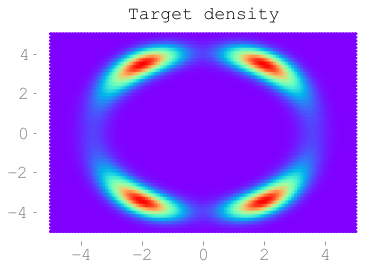

In [36]:
def density_ring(z):
    z1, z2 = tf.split(z, 2, axis=1)
    norm = tf.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = tf.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = tf.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - tf.math.log(exp1 + exp2)
    return tf.exp(-u)

# Plot it
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(z).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18);

Now to approximate such a complicated density, we will need to chain multiple planar flows and optimize their parameters to find a suitable approximation. We can do exactly that like in the following (you can see that we start by a simple normal density and perform 16 successive planar flows)

In [41]:
# Main class for normalizing flow
class NormalizingFlow():

    def __init__(self, dim, flow_length, density):
        super().__init__()
        biject_list = []
        for f in range(flow_length):
            biject_list.append(PlanarFlow(dim))
        self.bijectors = biject.Chain(biject_list)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.bijectors)
        self.final_density.sample(2)
        self.trainable_variables = self.final_density.trainable_variables
        self.log_det = []
    
    def log_prob(self, z):
        return self.final_density.log_prob(z)
    
    def _call(self, z):
        self.final_density(z)
    
# Create normalizing flow
flow = NormalizingFlow(dim=2, flow_length=16, density=distrib.MultivariateNormalDiag(tf.zeros(2), tf.ones(2)))

Now the only missing ingredient is the training function that is simply defined as follows

In [42]:
@tf.function
def train_density_estimation(distribution, optimizer, batch):
    """
    Train function for density estimation normalizing flows.
    :param distribution: TensorFlow distribution, e.g. tf.TransformedDistribution.
    :param optimizer: TensorFlow keras optimizer, e.g. tf.keras.optimizers.Adam(..)
    :param batch: Batch of the train data.
    :return: loss.
    """
    with tf.GradientTape() as tape:
        tape.watch(distribution.trainable_variables)
        loss = -tf.reduce_mean(distribution.log_prob(batch))  # negative log likelihood
    gradients = tape.gradient(loss, distribution.trainable_variables)
    optimizer.apply_gradients(zip(gradients, distribution.trainable_variables))
    return loss

We can now perform optimization as usual by defining an optimizer, the parameters it will act on and eventually a learning rate scheduler

In [44]:
base_lr = 1e-3
end_lr = 1e-4
# Maximum number of epochs of the training
max_epochs = int(1e5)
# Learning rate scheduler
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
# Crate optimizer object
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

And now we perform the loop by sampling a batch (here of 512) from the reference Normal distribution, and then evaluating our loss with respect to the density we want to approximate.

Loss (it. 0) : 8.557718276977539
Loss (it. 10000) : 2.8237502574920654
Loss (it. 20000) : 2.8573548793792725
Loss (it. 30000) : 2.895885467529297
Loss (it. 40000) : 2.8333358764648438
Loss (it. 50000) : 2.8688316345214844
Loss (it. 60000) : 2.829318046569824
Loss (it. 70000) : 2.7942633628845215
Loss (it. 80000) : 2.8278188705444336
Loss (it. 90000) : 2.812847852706909


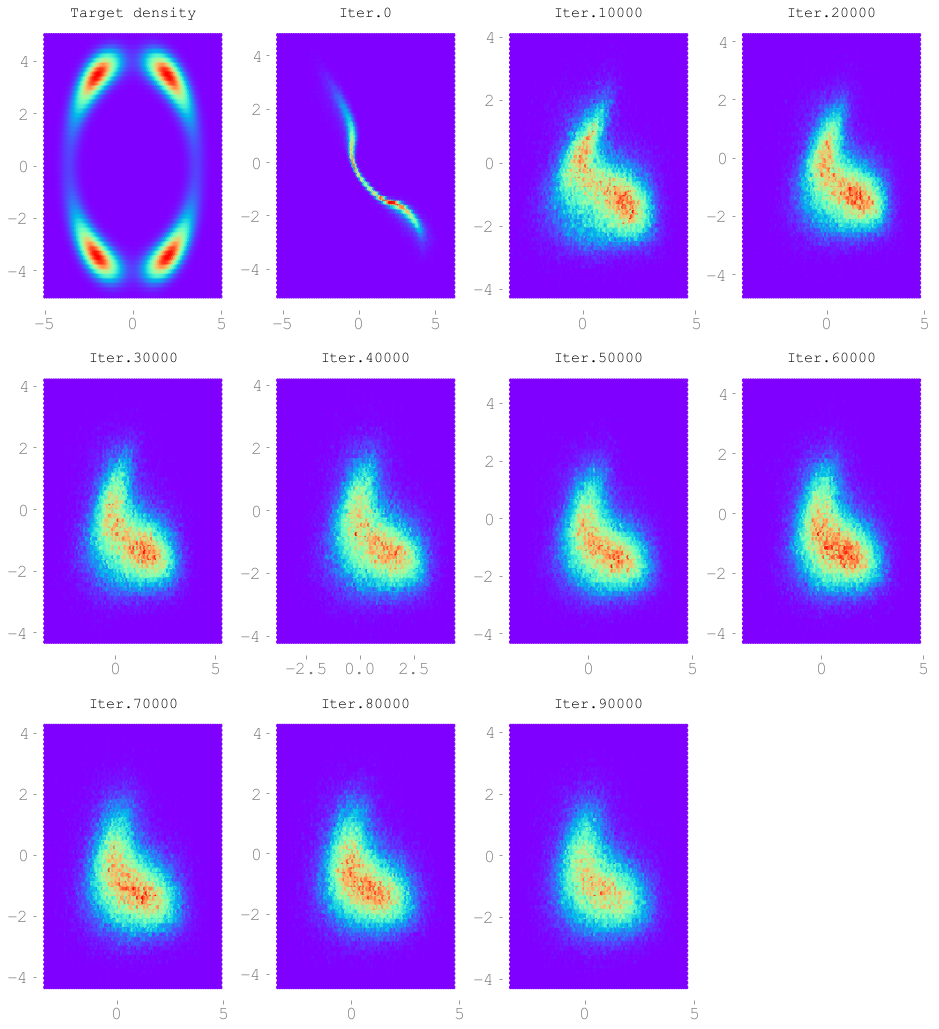

In [45]:
ref_distrib = distrib.MultivariateNormalDiag(tf.zeros(2), tf.ones(2))
id_figure=2
plt.figure(figsize=(16, 18))
plt.subplot(3,4,1)
plt.hexbin(z[:,0], z[:,1], C=density_ring(z).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=15);
# Main optimization loop
for it in range(max_epochs):
    # Draw a sample batch from Normal
    samples = ref_distrib.sample(512)
    # Evaluate flow of transforms
    train_loss = train_density_estimation(flow, opt, samples)
    if (it % 10000 == 0):
        print(f'Loss (it. {it}) : {train_loss}')
        # Draw random samples
        zk = flow.final_density.sample(int(1e5))
        # Evaluate flow and plot
        zk = zk.numpy()
        plt.subplot(3,4,id_figure)
        plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
        plt.title('Iter.%i'%(it), fontsize=15);
        id_figure += 1

That concludes this tutorial ! In the next one we will see how to implement more complicated flows and how this can fit in a global inference framework

<a id="vae"></a>
## Normalizing flows and VAEs - exercise

As we have seen in the previous section, one of the main limitations of VAEs is that they rely on a very simple family of approximations. In the original paper of Rezende [1], normalizing flows are used in order to complexify the posterior distribution of VAEs. 

### Flow-based free energy bound

If we parameterize the approximate posterior distribution with a flow of length $K$, $q_{\phi}(\mathbf{z}\vert\mathbf{x}) = q_K(\mathbf{z}_K)$, the free energy can be written as an expectation over the initial distribution $q_0(\mathbf{z})$

$$
\begin{align}
\mathcal{F}(\mathbf{x}) &= \mathbb{E}_{q_{\phi}(\mathbf{z}\vert\mathbf{x})}\left[
\text{log }q_{\phi}(\mathbf{z}\vert\mathbf{x}) - \text{log }p(\mathbf{x},\mathbf{z})\right]\\
&= \mathbb{E}_{q_0(z_0)}\left[\text{ln }q_{K}(\mathbf{z}_K) - \text{log }p(\mathbf{x},\mathbf{z}_K)\right] \\
&= \mathbb{E}_{q_0(z_0)}\left[\text{ln }q_{0}(\mathbf{z}_0)\right] - \mathbb{E}_{q_0(z_0)}\left[\text{log }p(\mathbf{x},\mathbf{z}_K)\right] - \mathbb{E}_{q_0(z_0)}\left[\sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|\right] 
\end{align}
$$

Normalizing flows and this free energy bound can be used with any variational optimization scheme. For amortized variational inference, we construct an inference model using a deep neural network to build a mapping from the observations $\mathbf{x}$ to the parameters of the initial density $q_0 = \mathcal{N}(\mu, \sigma)$ as well as the parameters of the flow $\lambda$.

This allows us to write the complete optimization objective as
$$
\mathcal{L}_{\theta, \phi} = \mathbb{E}_{q_0} \big[ \log{ p_\theta (\mathbf{x|z_k}) } \big] + \mathbb{E}_{q_0}\left[\text{ln }q_{0}(\mathbf{z}_0) - \text{log }p(\mathbf{z}_K)\right] - \mathbb{E}_{q_0}\left[\sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|\right] 
$$
   which can be optimized with stochastic gradient descent since $q_0$ is taken to be a Gaussian from which we can easily sample. However, now the final latent samples $\mathbf{z}_k$ will be drawn from a much more complex distribution. Also note that the previous KL criterion is replaced by two regularizations.

### Flows as posterior

In this first implementation of VAEs augmented with normalizing flows, we simply add a flow after the prior sampling. This is implemented in the following `VAENormalizingFlow` class. Note that the computation of different parts of the latent regularizations and the log determinants is performed explicitly here

In [192]:
class VAENormalizingFlow(tf.Module):
    
    def __init__(self, encoder, decoder, flow, encoder_dims, latent_dims):
        super(VAENormalizingFlow, self).__init__(encoder, decoder, encoder_dims, latent_dims)
        self.flow = flow

    def latent(self, x, z_params):
        return ...

As we can see, this model behaves almost exactly like the Vanilla `VAE`. However, we now complexify the latent distribution with a given `flow` and then replace the KL divergence with the regularization based on the variational free energy. Note also that we rely on the implementation of `Flow` from the previous tutorial, where each flow optimizes its own parameters. Therefore, we can simply optimize this model similarily as the previous one.

In [193]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Create normalizing flow
flow = ...
# Construct encoder and decoder
encoder, decoder = ..., ...
# Create VAE with planar flows
model_flow = ...
# Optimize our model
...

Ellipsis

Now we can compare this improved VAE model with a normalizing flow to the original vanilla VAE on our log-likelihood criterion

In [195]:
# Plot losses
...
# Evaluate log-likelihood and bits per dim
nll = ...
print('Negative Log-Likelihood : ' + str(nll))

Negative Log-Likelihood : Ellipsis


### Amortized inference.

Although the previous implementation of `VAENormalizingFlow` seems to work well, the parameters of the flows are optimized separately from the encoder function. However, when performing amortized inference for normalizing flows, the flow parameters determine the final distribution. Therefore, the parameters should also be considered functions of the datapoint $\mathbf{x}$.

In the original paper [1] and most implementations, the parameters of the flows are directly produced by the encoder network. This allow to simplify the computations, while increasing the correlations of these parameters to the input.

To do so, we are going to slightly modify our base implementation of the global `NormalizingFlow`, by providing two supplementary functions
1. `set_parameters` allow to update the parameters of all the flows contained in this class
2. `n_parameters` returns the total number of parameters present in the sequence 

In [196]:
# Main class for normalizing flow
class NormalizingFlow(tf.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        ...

    def _call(self, z):
        ...

Specifically for a given `Flow` operation (here we only modify the `PlanarFlow`, but this can be quite simply transposed), we are also adding two functions to obtain the number of parameters (summed dimensionnality of all tensors) and set their values. Here, we also change slightly the operation performed (compared to the previous tutorials), so that the flow parameters are actually *dependent on the input*. Therefore, the tensors will now be of dimensionality `batch_size x latent_dims`

In [197]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        ...

    def _call(self, z):
        ...

    def log_abs_det_jacobian(self, z):
        ...

Finally, we just need to make a few adjustments to the original class in order to account for this new way of optimizing the parameters. We simply add a separate encoder for the parameters (a linear layer), and also set the parameters of the `flow` before applying it to the samples.

In [199]:
class VAENormalizingFlow(tf.Module):
    
    def __init__(self, encoder, decoder, flow, encoder_dims, latent_dims):
        super(VAENormalizingFlow, self).__init__(encoder, decoder, encoder_dims, latent_dims)
        ...
            
    def encode(self, x):
        ...

    def latent(self, x, z_params):
        ...

Here, we re-optimize this modified `VAENormalizingFlow` class with the exact same procedure and hyper-parameters as the previous implementation

In [200]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Create normalizing flow
flow = ...
# Construct encoder and decoder
encoder, decoder = ..., ...
# Create VAE with planar flows
model_flow = ...
# Optimize our model
...

Ellipsis

Comparing this implementation regarding the log-likelihood and training curves, we have

In [202]:
# Plot losses
...
# Evaluate log-likelihood and bits per dim
nll = ...
print('Negative Log-Likelihood : ' + str(nll))

Negative Log-Likelihood : Ellipsis


### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[3] Germain, Mathieu, et al. "Made: masked autoencoder for distribution estimation." International Conference on Machine Learning. 2015.

### Inspirations and resources

https://blog.evjang.com/2018/01/nf1.html  
https://github.com/ex4sperans/variational-inference-with-normalizing-flows  
https://akosiorek.github.io/ml/2018/04/03/norm_flows.html  
https://github.com/abdulfatir/normalizing-flows  

